## Story with Data Assignment
I downloaded and created a similar data study from the sample using IPUMS data from a sample of individuals, again looking at race and education with instead working with the highspeed internet (CIHISPEED) and celludar data plans (CIDATAPLN) as the two additional variables. The sample only uses census data from 2016 and 2020 due to the fact that these were the first to studies that included questions about internet and mobile data access. The sample size includes 1533 households and 3205 individuals.

Also, I found the [ipumspy](https://ipumspy.readthedocs.io/en/latest/index.html) library to be able to work with the .dat file and DDI cookbook .xml file to create the dataframe.

The question is very similar to the sample study and looking to see if educational attainment and race affect access to high speed internet and mobile data plans.

High Speed Internet access is about 10x more likely with white individuals compared to Black or Asian individuals. Similar numbers are found for access to mobile data plans.

As for education, the biggest difference begins once someone has at least a high school degree (completed grade 12 or higher). Individuals in this category or 3 to 4 times more likely to have high speed internet access or a mobile data plan compared to those without a high school degree.

It's understood that there are limitations to this study given there are concerns about the race categories used in the US Census. Emma Sifre for the [Institute on Taxation and Economic Policy](https://itep.org/the-role-of-census-data-in-policy-and-racial-equity/) describes how the "Some Other Race" category which is becoming increasingly popular "is obscuring important differences in the racial identities of Americans." Given race is a social construct there are individuals that conflate race and enthicity assignments. For example, though the census requires 'Hispanic' to be considered an ethnic identity individuals of Latino background are also likely the majority of individuals choosing 'Some Other Race' as they may be intermingling ideas of race and ethnic identity.

4. Tell a story with the data analysis you've constructed, keeping in mind the key ideas from *Data Feminism*. This may include telling a story about what is absent from the data since power is related to counting, and not everything important is counted.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt 
import math

In [2]:
import researchpy as rp

In [8]:
!pip install ipumspy

     |████████████████████████████████| 128 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 12.1 MB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 14.2 MB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 259 kB 10.3 MB/s eta 0:00:01
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
  Attempting uninstall: click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.0
    Uninstalling beautifulsoup4-4.9.0:
      Successfully uninstalled beautifulsoup4-4.9.0
ERROR: pip's dependency r

In [9]:
from ipumspy import readers, ddi

In [12]:
ddi_codebook = readers.read_ipums_ddi('data/usa_00004.xml')
# download the zip file, uncompress and update the file path
IPUMS_df = readers.read_microdata(ddi_codebook, 'https://makercommons.org/data/usa_00004.dat.zip')

/Users/michaelsmith/opt/anaconda3/lib/python3.9/site-packages/ipumspy/readers.py:46: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


In [13]:
IPUMS_df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,CIDATAPLN,CIHISPEED,PERNUM,PERWT,RACE,RACED,EDUC,EDUCD
0,2016,201601,1,64,194.0,2016000000011,70001,1,2,10,1,196.0,1,100,7,71
1,2016,201601,1,64,194.0,2016000000011,70001,1,2,10,2,178.0,1,100,10,101
2,2016,201601,3,107,318.0,2016000000031,30201,1,1,10,1,320.0,1,100,8,81
3,2016,201601,3,107,318.0,2016000000031,30201,1,1,10,2,308.0,1,100,6,65
4,2016,201601,3,107,318.0,2016000000031,30201,1,1,10,3,368.0,1,100,6,63


### Codebook reference

#### CIHISPEED		Broadband (high speed) Internet service such as cable, fiber optic, or DSL service
* 00	N/A (GQ)
* 10	Yes (Cable modem, fiber optic or DSL service)
* 11	Cable modem only	·	·
* 12	Fiber optic only	·	·
* 13	DSL service only	·	·
* 14	Cable modem + Fiber optic	·	·
* 15	Cable modem + DSL service	·	·
* 16	Fiber optic + DSL service	·	·
* 17	Cable modem, Fiber optic and DSL service	·	·
* 20	No

#### CIDATAPLN		Cellular data plan for a smartphone or other mobile device
* 0 N/A (GQ)
* 1 Yes
* 2 No

#### RACE		Race [general version]
* 1		White
* 2		Black/African American/Negro
* 3		American Indian or Alaska Native
* 4		Chinese
* 5		Japanese
* 6		Other Asian or Pacific Islander
* 7		Other race, nec
* 8		Two major races
* 9		Three or more major races

#### EDUC		Educational attainment [general version]
* 00		N/A or no schooling
* 01		Nursery school to grade 4
* 02		Grade 5, 6, 7, or 8
* 03		Grade 9
* 04		Grade 10
* 05		Grade 11
* 06		Grade 12
* 07		1 year of college
* 08		2 years of college
* 09		3 years of college
10		4 years of college
11		5+ years of college

In [22]:
IPUMS2_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 1, :] # Selecting cases: RACE == 1, White
IPUMS3_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 2, :] # Selecting cases: RACE == 2, Black
IPUMS4a_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 4 , :] # Selecting cases: RACE > 3 & < 7, Asian
IPUMS4b_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 5 , :] # Selecting cases: RACE > 3 & < 7, Asian
IPUMS4c_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 6, :] # Selecting cases: RACE > 3 & < 7, Asian
IPUMS4_df = pd.concat([IPUMS4a_df, IPUMS4b_df, IPUMS4c_df], axis=0)

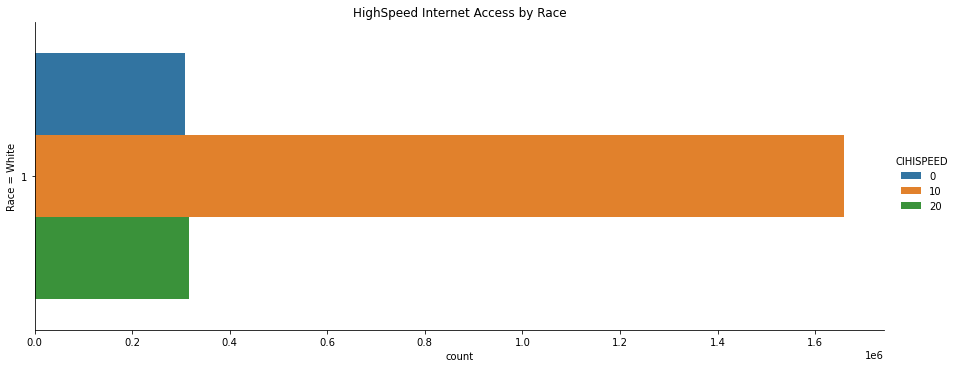

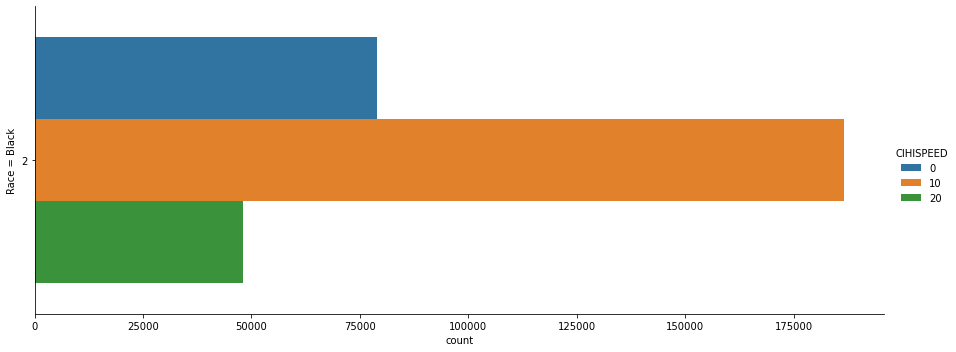

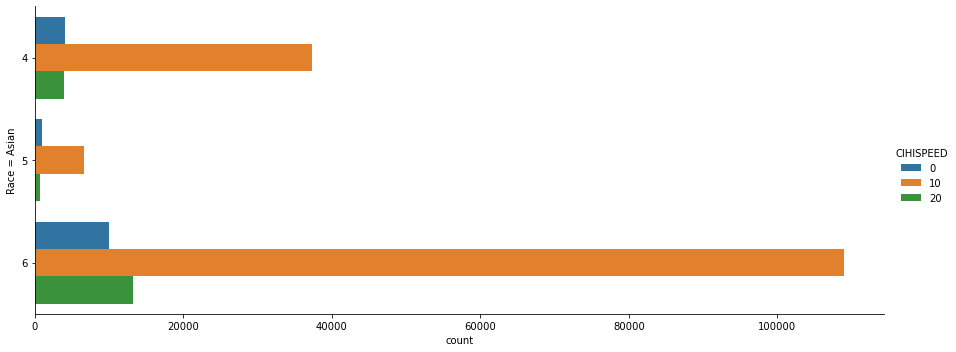

In [23]:
sb.catplot(hue='CIHISPEED', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS2_df)
plt.ylabel('Race = White')
plt.title('HighSpeed Internet Access by Race')
sb.catplot(hue='CIHISPEED', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS3_df)
plt.ylabel('Race = Black')
sb.catplot(hue='CIHISPEED', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS4_df)
plt.ylabel('Race = Asian')
plt.show()

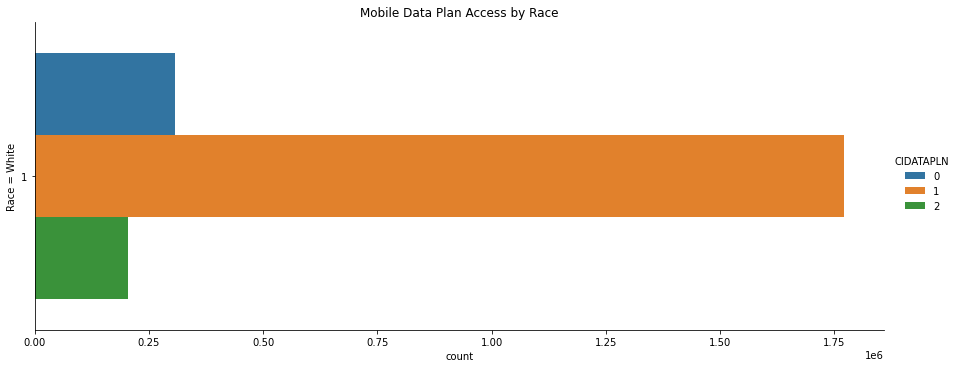

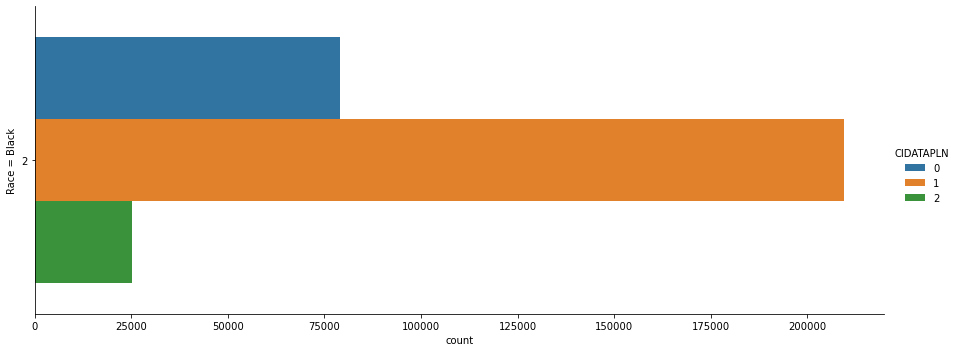

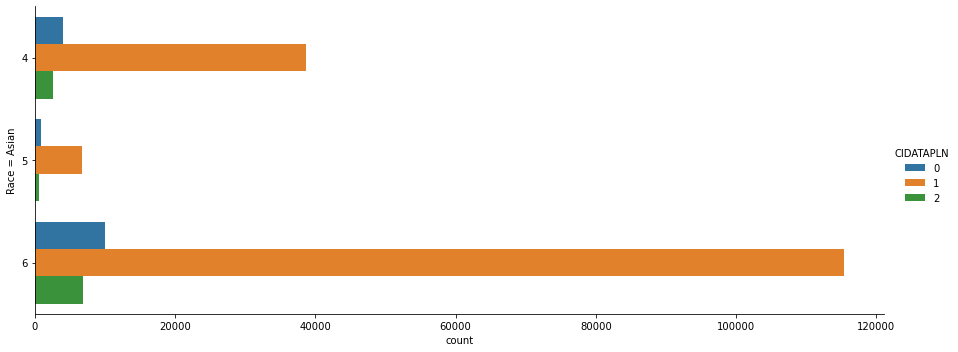

In [25]:
sb.catplot(hue='CIDATAPLN', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS2_df)
plt.ylabel('Race = White')
plt.title('Mobile Data Plan Access by Race')
sb.catplot(hue='CIDATAPLN', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS3_df)
plt.ylabel('Race = Black')
sb.catplot(hue='CIDATAPLN', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS4_df)
plt.ylabel('Race = Asian')
plt.show()

In [30]:
IPUMS5_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['EDUC'] <= 5, :] # Selecting cases: EDUC < 6, HS or less
IPUMS6_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['EDUC'] >= 6, :] # Selecting cases: EDUC > 7, College

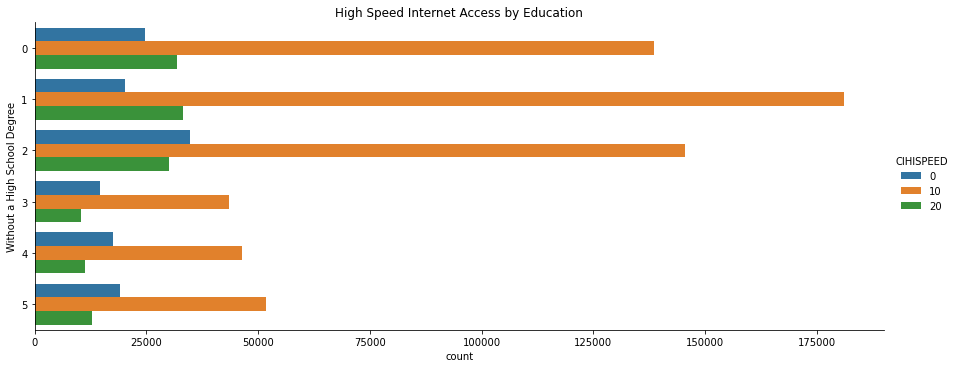

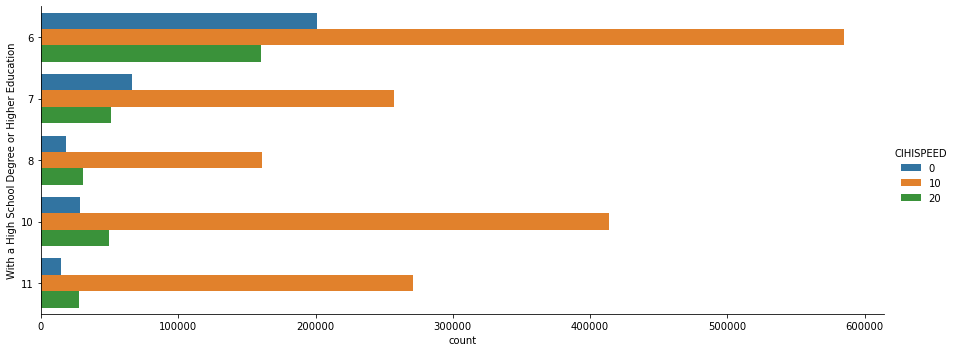

In [31]:
sb.catplot(hue='CIHISPEED', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS5_df)
plt.ylabel('Without a High School Degree')
plt.title('High Speed Internet Access by Education')
sb.catplot(hue='CIHISPEED', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS6_df)
plt.ylabel('With a High School Degree or Higher Education')
plt.show()

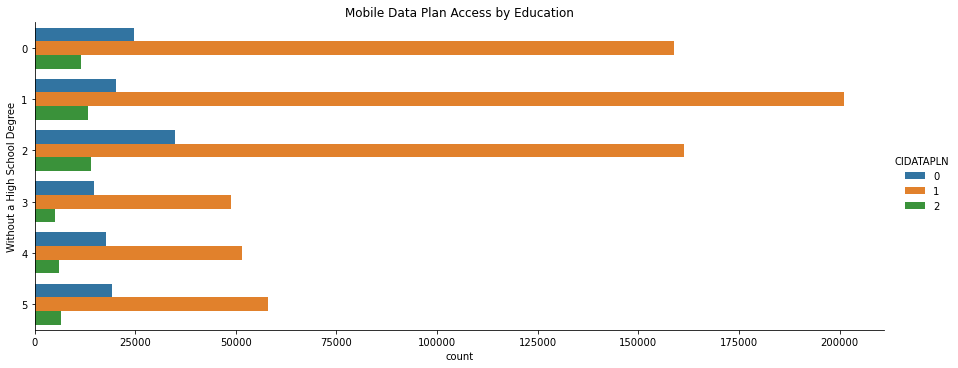

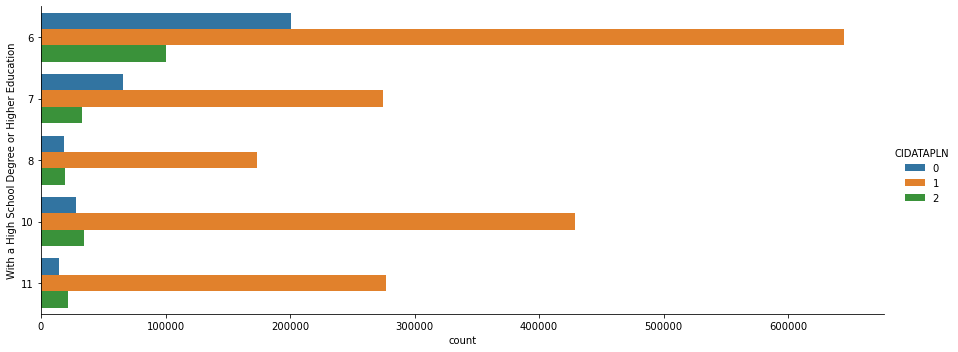

In [32]:
sb.catplot(hue='CIDATAPLN', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS5_df)
plt.ylabel('Without a High School Degree')
plt.title('Mobile Data Plan Access by Education')
sb.catplot(hue='CIDATAPLN', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS6_df)
plt.ylabel('With a High School Degree or Higher Education')
plt.show()